In [1]:
import os
import sys
# import cv2

import math

 
import time
import datetime
from datetime import timezone
 
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

import ccxt

import ta
import json

from utils import getIP, log_in, load_config
from strategy import populate_indicators


### Auth.py

In [2]:
# Check Ip Address (Make sure this IP address is whitelisted on Binance)

print('IP Address of the Machine: ', getIP())


IP Address of the Machine:  5.151.68.25


In [3]:

exchange = log_in()
print(exchange)


InvalidNonce: binance {"code":-1021,"msg":"Timestamp for this request was 1000ms ahead of the server's time."}

### Misceleneous

In [4]:
symbol = 'BTC/USDT'
type = 'limit'  # or 'market'
side = 'sell'  # or 'buy'
amount = 0.00008
price = 63743.04 

In [ ]:
# def fetch_coin_balance(symbol:str='BTC') -> float:
    
#     balances = pd.DataFrame(exchange.fetch_balance()['info']['balances'])
#     pair_balance = float(balances[balances['asset']==symbol]['free'].values[0])
#     locked_balance = float(balances[balances['asset']==symbol]['locked'].values[0])
#     return pair_balance, locked_balance

# print(fetch_coin_balance(symbol='BTC'))

In [ ]:
# print('Open Orders: ', exchange.fetch_open_orders(symbol))
# print('Len closed Orders: ', len(exchange.fetch_closed_orders(symbol)))
# exchange.create_market_buy_order(symbol, amount)
# print('Open Orders: ', exchange.fetch_open_orders(symbol))
# print('closed Orders: ', exchange.fetch_closed_orders(symbol))

In [ ]:
len(exchange.fetch_order_book('BTCUSDT')['asks'])
# print('Open Orders: ', pd.DataFrame(exchange.fetch_closed_orders(symbol)))

100

In [ ]:
#fetches all available currencies on an exchange
# exchange.fetch_currencies()

# retrieves data on all markets for binance
# exchange.fetch_markets()

# Query for Balance
exchange.fetch_balance()



{'info': {'makerCommission': '10',
  'takerCommission': '10',
  'buyerCommission': '0',
  'sellerCommission': '0',
  'commissionRates': {'maker': '0.00100000',
   'taker': '0.00100000',
   'buyer': '0.00000000',
   'seller': '0.00000000'},
  'canTrade': True,
  'canWithdraw': True,
  'canDeposit': True,
  'brokered': False,
  'requireSelfTradePrevention': False,
  'preventSor': False,
  'updateTime': '1714312919319',
  'accountType': 'SPOT',
  'balances': [{'asset': 'BTC', 'free': '0.00009000', 'locked': '0.00000000'},
   {'asset': 'LTC', 'free': '0.00000000', 'locked': '0.00000000'},
   {'asset': 'ETH', 'free': '0.00000000', 'locked': '0.00000000'},
   {'asset': 'NEO', 'free': '0.00000000', 'locked': '0.00000000'},
   {'asset': 'BNB', 'free': '0.00076610', 'locked': '0.00000000'},
   {'asset': 'QTUM', 'free': '0.00000000', 'locked': '0.00000000'},
   {'asset': 'EOS', 'free': '0.00000000', 'locked': '0.00000000'},
   {'asset': 'SNT', 'free': '0.00000000', 'locked': '0.00000000'},
   {'

In [ ]:

def create_order():
    # exchange = ccxt.pro.binance({
    #     'apiKey': 'YOUR_API_KEY',
    #     'secret': 'YOUR_SECRET',
    # })

    markets = exchange.load_markets()

    # exchange.verbose = True  # uncomment for debugging purposes if necessary

    symbol = 'ETH/BTC'
    type = 'limit'  # or 'market'
    side = 'sell'  # or 'buy'
    amount = 1.0
    price = 0.060154  # or None

    order = exchange.create_order(symbol, type, side, amount, price)
    print('Open Orders: ', exchange.fetch_open_orders())
    canceled = exchange.cancel_order(order['id'], order['symbol'])
    print('Open Orders 2nd time: ', exchange.fetch_open_orders())

    print(canceled)

    exchange.close()

def main():
    create_order()
    


main()

In [ ]:
symbol = 'BTC/USDT'
type = 'limit'  # or 'market'
side = 'sell'  # or 'buy'
amount = 0.00008
price = 63743.04  # or None

# order = exchange.create_order(symbol, type, side, amount, price)

In [ ]:
days = 25 
from_timestamp = exchange.milliseconds() - days * 86400 * 1000 * 1
data = exchange.fetch_ohlcv('BTC/USDT', '1d', from_timestamp)
print(len(data))
data

In [ ]:
account_balance = pd.DataFrame(exchange.fetch_balance()['info']['balances'])
account_balance[account_balance['asset']=='USDT']

In [ ]:
account_balance.free.astype('float32').sum()

In [ ]:
exchange.positions

In [ ]:
starting_usdt = 1000
starting_coin = 0
trading_fees = 0.001

In [ ]:
help(exchange.fetch_ohlcv)

Help on method fetch_ohlcv in module ccxt.binance:

fetch_ohlcv(symbol: str, timeframe='1m', since: Optional[int] = None, limit: Optional[int] = None, params={}) -> List[list] method of ccxt.binance.binance instance
    fetches historical candlestick data containing the open, high, low, and close price, and the volume of a market
    :see: https://binance-docs.github.io/apidocs/spot/en/#kline-candlestick-data
    :see: https://binance-docs.github.io/apidocs/voptions/en/#kline-candlestick-data
    :see: https://binance-docs.github.io/apidocs/futures/en/#index-price-kline-candlestick-data
    :see: https://binance-docs.github.io/apidocs/futures/en/#mark-price-kline-candlestick-data
    :see: https://binance-docs.github.io/apidocs/futures/en/#kline-candlestick-data
    :see: https://binance-docs.github.io/apidocs/delivery/en/#index-price-kline-candlestick-data
    :see: https://binance-docs.github.io/apidocs/delivery/en/#mark-price-kline-candlestick-data
    :see: https://binance-docs.git

In [ ]:
since = '2024-04-30T00:00:00'
if isinstance(since, str):
    since = exchange.parse8601(since)
    print(since)
    print(datetime.datetime.fromtimestamp(since/1000.0))

1714435200000
2024-04-30 01:00:00


## Actual Code

In [2]:
class TradingBot:
    def __init__(self, config:str= 'config.json', exchange=None, name='Freedom 25'):
        
        print(f'Hi I am {name}, To your service')
        self.config = load_config(config)
        self.exchange = exchange
        
        if self.exchange:
            try:
                self.exchange = log_in() #exchange
                self.exchange.load_markets()
                print('Successfully Connected to the Exchange')
            except:
                self.exchange = None
                print('Unable to Connect to the Exchange')
                print('working only with the historical data')
        
        # else
        # os.system('pwd')
        
    def get_historical_prices(self, symbols:str='BTC/USDT', timeframe:str='1d', days:int = 500, start: datetime = None, end: datetime = None, save:bool=False)-> pd.DataFrame:
        if self.exchange:
            from_timestamp = self.exchange.milliseconds() - days * 86400 * 1000
            to_timestamp = self.exchange.milliseconds() - (days-10) * 86400 * 1000
            # bars = exchange.fetch_ohlcv(symbols, timeframe)
            
            if days:
                print(f'Fetching past {days} days data for {symbols} || Timeframe: {timeframe}')
                bars = self.exchange.fetch_ohlcv(symbols, timeframe=timeframe, since=from_timestamp, limit=1000)
            
            #TODO: from-to timestamp data fetch
            if start:
                if end:
                    pass
                else:
                    pass
                

            # bars = exchange.fetch_ohlcv(symbols, timeframe=timeframe, since=from_timestamp,  params={'until': to_timestamp}, limit=1000)
            df = pd.DataFrame(bars[:-1], columns=['date', 'open', 'high', 'low', 'close', 'volume'])
            df['date'] = pd.to_datetime(df['date'], unit='ms')
            df['date'] = df['date'].dt.strftime('%Y-%m-%d %H:%M:%S')
            df["close"] = pd.to_numeric(df["close"])
            df["high"] = pd.to_numeric(df["high"])
            df["low"] = pd.to_numeric(df["low"])
            df["open"] = pd.to_numeric(df["open"])
            
            if save:
                filename = f'{symbols}_{days}_days.csv' #'test.csv'
                print(filename)
                df.to_csv(filename)
            
            return df
        return None
    
    def fetch_coin_balance(self, symbol:str='BTC') -> float:
        balances = pd.DataFrame(self.exchange.fetch_balance()['info']['balances'])
        pair_balance = float(balances[balances['asset']==symbol]['free'].values[0])
        return pair_balance
    
    
    
    
    def load_config():
        pass
    
     
    def plot_data(self, dataframe:pd.DataFrame):
        pass
    
    def create_trade(self):
        pass
    
    def execute_signals(self):
        pass
    
    def execute_trades(self):
        pass
    
    def run(self, historical_data=None):
        if self.exchange:
            try:
                df = self.get_historical_prices(symbols=self.config['symbol'], timeframe='1d', days=500)
            except:
                print('Unable to fetch historical Data. Falling back to historical data')
        else:
            if historical_data:
                df = pd.read_csv(historical_data)
            else:
                raise ValueError('Data could not be fetched.')
            
        # print(df.head())
        # print(df.tail())
        signal_df = populate_indicators(df)
        print(signal_df.tail()) 
        return signal_df

In [3]:
def main():
    config_file = '/home/tamal/projects/TradingBot/config.json'
    historical_data = '/home/tamal/projects/TradingBot/BTC_USDT_500_days.csv'
    
    bot = TradingBot(config_file, exchange='binance', name='Willi')
    bot.run(historical_data)
    

signal_df = main()   

Hi I am Willi, To your service
Unable to Connect to the Exchange
working only with the historical data
     Unnamed: 0                 date      open      high       low     close  \
494         494  2024-04-25 00:00:00  64289.58  65297.94  62794.00  64498.34   
495         495  2024-04-26 00:00:00  64498.33  64820.01  63297.48  63770.01   
496         496  2024-04-27 00:00:00  63770.00  63923.41  62391.24  63461.98   
497         497  2024-04-28 00:00:00  63461.98  64370.00  62781.00  63118.62   
498         498  2024-04-29 00:00:00  63118.62  64228.35  61765.53  63866.00   

          volume      MA-st        MA-lt          EMAf          EMAs  \
494  31341.46338  64426.184  66963.51250  65097.259797  65830.430080   
495  27085.19346  64423.846  66847.92575  64855.941652  65697.499752   
496  20933.06052  64642.307  66744.22550  64602.494079  65553.272671   
497  16949.20005  64607.161  66773.75600  64332.698792  65396.198305   
498  28150.22947  64611.960  66674.39325  64247.844466  

In [4]:
def buy_condition(row): #entry
        if row['MA-st'] > row['MA-lt']:
            return True
        else:
            return False
        
    #     return row['MA-st'] > row['MA-lt']:

def sell_condition(row): #exit
    if row['MA-st'] < row['MA-lt']:
        return True
    else:
        return False

In [5]:
def calculate_position_size(balance, exposure, entry_price, stop_loss_price):
    if exposure == 'all':
        return balance
    risked_amount = balance * (exposure / 100)
    position = risked_amount * entry_price / abs(entry_price - stop_loss_price)
    return min(balance, position)

calculate_position_size(1000, 10, 10, 8)

500.0

## Complete Backtest

## Asset

In [6]:
name_base = "BTC"
name_quote = "USDT"

### Data

In [7]:
timeframe = "1d"
starting_date_backtest = "01 january 2019"
ending_date_backtest =  "01 january 2022"
starting_date_dl = "01 january 2018"
ending_date_dl = "01 january 2022"

### Portfolio

In [8]:
initial_capital = 1000 # in quote
exposure = 2           # position size in percent
# exposure = 'all'       # use this instead if you want 100% of your portfolio to be used for each trade
trade_fees = 0.1       # in percent
leverage = 5

### ignores

In [9]:
ignore_shorts = False
ignore_longs = False

ignore_tp = False
ignore_sl = False
ignore_exit = False

### Existing Data

In [10]:
data_dl = pd.read_csv('BTC_USDT_500_days.csv')
data_dl.head()

,Unnamed: 0,date,open,high,low,close,volume
0,0,2022-12-18 00:00:00,16777.54,16863.26,16663.07,16738.21,112619.31646
1,1,2022-12-19 00:00:00,16739.00,16815.99,16256.30,16438.88,179094.28305
2,2,2022-12-20 00:00:00,16438.88,17061.27,16397.20,16895.56,248808.92324
3,3,2022-12-21 00:00:00,16896.15,16925.00,16723.00,16824.67,156810.96362
4,4,2022-12-22 00:00:00,16824.68,16868.52,16559.85,16821.43,176044.27235


### Core Functions

In [11]:
def calculate_position_size(balance, exposure, entry_price, stop_loss_price):
    if exposure == 'all':
        return balance
    risked_amount = balance * (exposure / 100)
    position = risked_amount * entry_price / abs(entry_price - stop_loss_price)
    return min(balance, position)


def calculate_liquidation_price(price, leverage, order_type):
        if order_type == 'long':
            return price * (1 - 1 / leverage)
        elif order_type == 'short':
            return price * (1 + 1 / leverage)


def calculate_pnl(entry_price, exit_price, quantity, order_type):
    if order_type == 'long':
        return (exit_price - entry_price) * quantity
    elif order_type == 'short':
        return (entry_price - exit_price) * quantity
    

def record_order(timestamp, type, price, amount, pnl, wallet, fee, orders):
    order = {
        'timestamp': timestamp,
        'type': type,
        'amount': amount,
        'fee': fee,
        'pnl': pnl,
        'wallet': wallet,
    }
    orders.append(order)
    print(f"{type} at {price} {name_quote} on {timestamp}, amount = {round(amount,2)} {name_quote}, pnl = {round(pnl,2)} {name_quote}, wallet = {round(wallet,2)} {name_quote}")

### Longs

In [12]:
def check_long_entry_condition(row, previous_row):
    return row['close'] > row['Trend'] and row['EMAf'] > row['EMAs'] and previous_row['EMAf'] < previous_row['EMAs'] and row['RSI'] < 70


def check_long_exit_condition(row, previous_row):
    return row['EMAf'] < row['EMAs'] and previous_row['EMAf'] > previous_row['EMAs']


def compute_long_sl_level(row, entry_price):
    return entry_price - 2 * row['ATR']


def compute_long_tp_level(row, entry_price, stop_loss_price):
    risk_reward_ratio = 4
    return entry_price * (1 + risk_reward_ratio * (1 - stop_loss_price / entry_price))
    # return row['open'] * 1.1

### Shorts

In [13]:
def check_short_entry_condition(row, previous_row):
    return row['close'] < row['Trend'] and row['EMAf'] < row['EMAs'] and previous_row['EMAf'] > previous_row['EMAs'] and row['RSI'] > 30


def check_short_exit_condition(row, previous_row):
    return row['EMAf'] > row['EMAs'] and previous_row['EMAf'] < previous_row['EMAs']


def compute_short_sl_level(row, entry_price):
    return entry_price + 2 * row['ATR']


def compute_short_tp_level(row, entry_price, stop_loss_price):
    risk_reward_ratio = 4
    return entry_price * (1 - risk_reward_ratio * (stop_loss_price / entry_price - 1))

In [38]:
data = data_dl #populate_indicators(data_dl)
data.tail()

,Unnamed: 0,date,open,high,low,close,volume
494,494,2024-04-25 00:00:00,64289.58,65297.94,62794.00,64498.34,31341.46338
495,495,2024-04-26 00:00:00,64498.33,64820.01,63297.48,63770.01,27085.19346
496,496,2024-04-27 00:00:00,63770.00,63923.41,62391.24,63461.98,20933.06052
497,497,2024-04-28 00:00:00,63461.98,64370.00,62781.00,63118.62,16949.20005
498,498,2024-04-29 00:00:00,63118.62,64228.35,61765.53,63866.00,28150.22947


In [39]:
data = data.rename(columns={'date':'timestamp'})
data.head()

,Unnamed: 0,timestamp,open,high,low,close,volume
0,0,2022-12-18 00:00:00,16777.54,16863.26,16663.07,16738.21,112619.31646
1,1,2022-12-19 00:00:00,16739.00,16815.99,16256.30,16438.88,179094.28305
2,2,2022-12-20 00:00:00,16438.88,17061.27,16397.20,16895.56,248808.92324
3,3,2022-12-21 00:00:00,16896.15,16925.00,16723.00,16824.67,156810.96362
4,4,2022-12-22 00:00:00,16824.68,16868.52,16559.85,16821.43,176044.27235


In [40]:
from strategy import populate_indicators, Strategy

s1 = Strategy(data, strategy='s1')
data = s1.data
data.iloc[:,-4:]

,short_entry,short_exit,long_entry,long_exit
0,False,False,False,False
1,False,False,False,False
2,False,False,False,False
3,False,False,False,False
4,False,False,False,False
...,...,...,...,...
494,False,False,False,False
495,False,False,False,False
496,False,False,False,False
497,False,False,False,False


In [43]:
def run_backtest(data):

    # Initialize variables
    orders = []
    order_in_progress = None
    last_ath = 0
    sl_price = 0
    tp_price = 0
    long_liquidation_price = 0
    short_liquidation_price = 1e10
    wallet = initial_capital
    data['realised_pnl'] = ''
    data['unrealised_pnl'] = ''
    data['hodl'] = ''
    data['drawdown'] = ''
    # previous_row = data.iloc[0]


    # Go through data and make trades
    for index, row in data.iterrows():
        price = row['close']
        # print(price)


        # check if it is time to close a long (LONG EXIT)
        if order_in_progress == 'long' and not ignore_longs:
            if row['low'] < long_liquidation_price:
                print(f' ! Your long was liquidated on the {row["timestamp"]} (price = {long_liquidation_price} {name_quote})')
                sys.exit()

            elif not ignore_sl and row['low'] <= sl_price:
                pnl = calculate_pnl(entry_price, sl_price, quantity, order_in_progress)
                fee_exit = quantity * sl_price * trade_fees / 100
                wallet += position - fee_entry + pnl - fee_exit
                record_order(row['timestamp'], 'long sl', sl_price, 0, pnl - fee_exit - fee_entry, wallet, fee_exit, orders)
                order_in_progress = None

            elif not ignore_tp and row['high'] >= tp_price:
                pnl = calculate_pnl(entry_price, tp_price, quantity, order_in_progress)
                fee_exit = quantity * tp_price * trade_fees / 100
                wallet += position - fee_entry + pnl - fee_exit
                record_order(row['timestamp'], 'long tp', tp_price, 0, pnl - fee_exit - fee_entry, wallet, fee_exit, orders)
                order_in_progress = None

            elif not ignore_exit and row['long_exit']:#check_long_exit_condition(row, previous_row):
                pnl = calculate_pnl(entry_price, price, quantity, order_in_progress)
                fee_exit = quantity * price * trade_fees / 100
                wallet += position - fee_entry + pnl - fee_exit
                record_order(row['timestamp'], 'long exit', price, 0, pnl - fee_exit - fee_entry, wallet, fee_exit, orders)
                order_in_progress = None

            if wallet > last_ath:
                last_ath = wallet


        # check if it is time to close a short (SHORT EXIT)
        elif order_in_progress == 'short' and not ignore_shorts:
            if row['high'] > short_liquidation_price:
                print(f'!Your short was liquidated on the {row["timestamp"]} (price = {short_liquidation_price} {name_quote})')
                sys.exit()

            elif not ignore_sl and row['high'] >= sl_price:
                pnl = calculate_pnl(entry_price, sl_price, quantity, order_in_progress)
                fee_exit = quantity * sl_price * trade_fees / 100
                wallet += position - fee_entry + pnl - fee_exit
                record_order(row['timestamp'], 'short sl', sl_price, 0, pnl - fee_exit - fee_entry, wallet, fee_exit, orders)
                order_in_progress = None

            elif not ignore_tp and row['low'] <= tp_price:
                pnl = calculate_pnl(entry_price, tp_price, quantity, order_in_progress)
                fee_exit = quantity * tp_price * trade_fees / 100
                wallet += position - fee_entry + pnl - fee_exit
                record_order(row['timestamp'], 'short tp', tp_price, 0, pnl - fee_exit - fee_entry, wallet, fee_exit, orders)
                order_in_progress = None

            elif not ignore_exit and row['short_exit']:  #check_short_exit_condition(row, previous_row):
                pnl = calculate_pnl(entry_price, price, quantity, order_in_progress)
                fee_exit = quantity * price * trade_fees / 100
                wallet += position - fee_entry + pnl - fee_exit
                record_order(row['timestamp'], 'short exit', price, 0, pnl - fee_exit - fee_entry, wallet, fee_exit, orders)
                order_in_progress = None

            if wallet > last_ath:
                last_ath = wallet


        # check it is time to enter a long (LONG ENTRY)
        if not ignore_longs and order_in_progress == None:
            if row['long_entry']:   #check_long_entry_condition(row, previous_row):
                order_in_progress = 'long'
                if not ignore_sl:
                    sl_price = compute_long_sl_level(row, price)
                if not ignore_tp:
                    tp_price = compute_long_tp_level(row, price, sl_price)
                entry_price = price
                position = calculate_position_size(wallet, exposure, price, sl_price)
                amount = position * leverage
                fee_entry = amount * trade_fees / 100
                quantity = (amount - fee_entry) / price
                long_liquidation_price = calculate_liquidation_price(price, leverage, order_in_progress)
                if wallet > last_ath:
                    last_ath = wallet

                wallet -= position
                record_order(row['timestamp'], 'long entry', price, amount-fee_entry, -fee_entry, wallet, fee_entry, orders)


        # check if it is time to enter a short (SHORT ENTRY)
        if not ignore_shorts and order_in_progress == None:
            if row['short_entry']:  #check_short_entry_condition(row, previous_row):
                order_in_progress = 'short'
                if not ignore_sl:
                    sl_price = compute_short_sl_level(row, price)
                if not ignore_tp:
                    tp_price = compute_short_tp_level(row, price, sl_price)
                entry_price = price
                position = calculate_position_size(wallet, exposure, price, sl_price)
                amount = position * leverage
                fee_entry = amount * trade_fees / 100
                quantity = (amount - fee_entry) / price
                short_liquidation_price = calculate_liquidation_price(price, leverage, order_in_progress)
                wallet -= position
                record_order(row['timestamp'], 'short entry', price, amount-fee_entry, -fee_entry, wallet, fee_entry, orders)


        # updating wallet info
        data.at[index, 'realised_pnl'] = wallet
        data.at[index, 'unrealised_pnl'] = data.at[index, 'realised_pnl']
        if order_in_progress != None:
            data.at[index, 'unrealised_pnl'] += position + calculate_pnl(entry_price, price, quantity, order_in_progress) #- fee
        data.at[index, 'hodl'] = initial_capital / data["close"].iloc[0] * price
        data.at[index, 'drawdown'] = (data.at[index, 'unrealised_pnl'] - last_ath) / last_ath if last_ath else 0

        # previous_row = row

    return data, orders

In [44]:
def analyze_backtest(data, backtest_orders):
    ## Profits
    show_unrealised = True
    show_realised = False
    show_hodl = True

    profits_bot_realised = ((data['realised_pnl'] - initial_capital)/initial_capital) * 100
    profits_bot_unrealised = ((data['unrealised_pnl'] - initial_capital)/initial_capital) * 100
    profits_hodl = ((data['hodl'] - data.iloc[0]['hodl'])/data.iloc[0]['hodl']) * 100

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
    if show_unrealised:
        ax1.plot(data['timestamp'], profits_bot_unrealised, color='gold', label='Bot')
    if show_realised:
        ax1.plot(data['timestamp'], profits_bot_realised, color='gold', label='Bot (realised)', ls= '--')
    if show_hodl:
        ax1.plot(data['timestamp'], profits_hodl, color='purple', label='Hodl')
    ax1.set_title('Net Profits', fontsize=20)
    ax1.set_ylabel('Net Profits (%)', fontsize=18)
    ax1.set_xticklabels([])
    ax1.legend(fontsize=16)
    if show_unrealised:
        ax2.plot(data['timestamp'], data['unrealised_pnl'], color='gold', label='Bot')
    if show_realised:
        ax2.plot(data['timestamp'], data['realised_pnl'], color='gold', label='Bot (realised)', ls= '--')
    if show_hodl:
        ax2.plot(data['timestamp'], data['hodl'], color='purple', label='Hodl')
    ax2.set_xlabel('Period', fontsize=18)
    ax2.set_ylabel('Net Profits (' + name_quote + ')', fontsize=18)
    ax2.tick_params(axis='both', which='major', labelsize=12, rotation = 45)

    print(f" \n\n      ** Profits ** \n")
    print(f" > Period: {data['timestamp'].iloc[0]} -> {data['timestamp'].iloc[-1]} ")
    print(f" > Starting balance: {initial_capital} {name_quote}")
    print(f" > Final balance Bot: {round(data.iloc[-1]['unrealised_pnl'],2)} {name_quote}")
    print(f" > Final balance Hodl: {round(data.iloc[-1]['hodl'],2)} {name_quote}")
    print(f" > Bot net profits: {round(profits_bot_unrealised.iloc[-1],2)}%")
    print(f" > Hodl net profits: {round(profits_hodl.iloc[-1],2)}%")
    print(f" > Net profits ratio Bot / Hodl: {round(data.iloc[-1]['unrealised_pnl']/data.iloc[-1]['hodl'],2)}")


    ## Trades
    orders = pd.json_normalize(backtest_orders, sep='_')
    n_orders = len(orders.index)
    if not ignore_longs:
        n_longs = orders['type'].value_counts()['long entry']
    else:
        n_longs = 0
    if not ignore_shorts:
        n_shorts = orders['type'].value_counts()['short entry']
    else:
        n_shorts = 0
    n_entry_orders = 0
    if not ignore_longs:
        n_entry_orders += orders['type'].value_counts()['long entry']
    if not ignore_shorts:
        n_entry_orders += orders['type'].value_counts()['short entry']

    n_exit_orders = 0
    if 'long exit' in orders['type'].value_counts():
        n_exit_orders += orders['type'].value_counts()['long exit']
    if 'long tp' in orders['type'].value_counts():
        n_exit_orders += orders['type'].value_counts()['long tp']
    if 'long sl' in orders['type'].value_counts():
        n_exit_orders += orders['type'].value_counts()['long sl']
    if 'short exit' in orders['type'].value_counts():
        n_exit_orders += orders['type'].value_counts()['short exit']
    if 'short tp' in orders['type'].value_counts():
        n_exit_orders += orders['type'].value_counts()['short tp']
    if 'short sl' in orders['type'].value_counts():
        n_exit_orders += orders['type'].value_counts()['short sl']

    orders.loc[::2, 'pnl'] = np.nan
    orders['Win'] = ''
    orders.loc[orders['pnl']>0,'Win'] = 'Yes'
    orders.loc[orders['pnl']<=0,'Win'] = 'No'
    if 'Yes' in orders['Win'].value_counts():
        n_pos_trades = orders['Win'].value_counts()['Yes']
    else:
        n_pos_trades = 0
    if 'No' in orders['Win'].value_counts():
        n_neg_trades = orders['Win'].value_counts()['No']
    else:
        n_neg_trades = 0

    winrate = round(n_pos_trades / (n_pos_trades+n_neg_trades) * 100,2)
    orders['pnl%'] = orders['pnl'] / (orders['wallet'] - orders['pnl'])  * 100
    avg_trades = round(orders['pnl%'].mean(),2)
    avg_pos_trades = round(orders.loc[orders['Win'] == 'Yes']['pnl%'].mean(),2)
    avg_neg_trades = round(orders.loc[orders['Win'] == 'No']['pnl%'].mean(),2)
    best_trade = orders['pnl%'].max()
    when_best_trade = orders['timestamp'][orders.loc[orders['pnl%'] == best_trade].index.tolist()[0]]
    best_trade = round(best_trade,2)
    worst_trade = orders['pnl%'].min()
    when_worst_trade = orders['timestamp'][orders.loc[orders['pnl%'] == worst_trade].index.tolist()[0]]
    worst_trade = round(worst_trade,2)

    print(f" \n\n      ** Trades ** \n")
    print(f" > Orders: {n_orders} ({n_entry_orders} buys, {n_exit_orders} sells)")
    print(f" > Number of closed trades: {n_pos_trades+n_neg_trades}")
    print(f" > Winrate: {winrate}%")
    print(f" > Average trade profits: {avg_trades}%")
    print(f" > Number of winning trades: {n_pos_trades}")
    print(f" > Number of losing trades: {n_neg_trades}")
    print(f" > Average winning trades: {avg_pos_trades}%")
    print(f" > Average losing trades: {avg_neg_trades}%")
    print(f" > Best trade: {best_trade}% on the {when_best_trade}")
    print(f" > Worst trade: {worst_trade}% on the {when_worst_trade}")


    ## Health
    worst_drawdown = round(data['drawdown'].min()*100,2)
    profit_factor = round(abs(orders.loc[orders['pnl'] > 0, 'pnl'].sum() / orders.loc[orders['pnl'] < 0, 'pnl'].sum()),2)
    return_over_max_drawdown = round(profits_bot_unrealised.iloc[-1] / abs(worst_drawdown),2)

    print(f" \n\n      ** Health ** \n")
    print(f" > Maximum drawdown: {worst_drawdown}%")
    print(f" > Profit factor: {profit_factor}")
    print(f" > Return over maximum drawdown: {return_over_max_drawdown}")


    ## fees
    total_fee = round(orders['fee'].sum(),2)
    biggest_fee = round(orders['fee'].max(),2)
    avg_fee = round(orders['fee'].mean(),2)

    print(f" \n\n      ** Fees ** \n")
    print(f" > Total: {total_fee} {name_quote}")
    print(f" > Biggest: {biggest_fee} {name_quote}")
    print(f" > Average: {avg_fee} {name_quote} \n")

short entry at 22410.0 USDT on 2023-03-06 00:00:00, amount = 1393.19 USDT, pnl = -1.39 USDT, wallet = 721.08 USDT
short sl at 24016.92726381811 USDT on 2023-03-13 00:00:00, amount = 0 USDT, pnl = -102.79 USDT, wallet = 897.21 USDT
long entry at 24285.66 USDT on 2023-03-15 00:00:00, amount = 934.73 USDT, pnl = -0.94 USDT, wallet = 710.08 USDT
long exit at 27628.27 USDT on 2023-05-09 00:00:00, amount = 0 USDT, pnl = 126.65 USDT, wallet = 1023.87 USDT
short entry at 27628.27 USDT on 2023-05-09 00:00:00, amount = 1350.14 USDT, pnl = -1.35 USDT, wallet = 753.57 USDT
short sl at 29721.33495659421 USDT on 2023-06-21 00:00:00, amount = 0 USDT, pnl = -105.09 USDT, wallet = 918.78 USDT
long entry at 26906.96 USDT on 2023-09-29 00:00:00, amount = 1967.68 USDT, pnl = -1.97 USDT, wallet = 524.85 USDT
long tp at 31927.464032002546 USDT on 2023-10-23 00:00:00, amount = 0 USDT, pnl = 362.84 USDT, wallet = 1281.62 USDT
short entry at 41327.5 USDT on 2024-01-18 00:00:00, amount = 1310.89 USDT, pnl = -1.

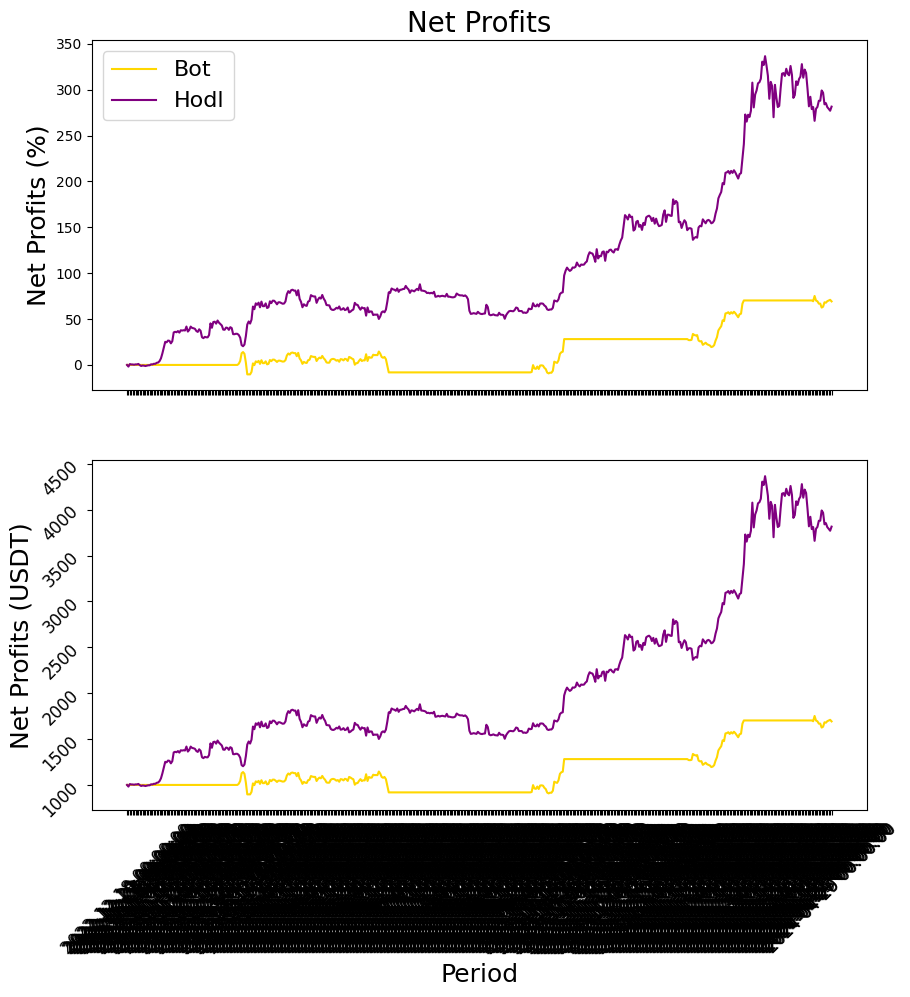

In [45]:
data, backtest_orders = run_backtest(data)
analyze_backtest(data, backtest_orders)
# data.head()

In [27]:
data.iloc[:, -8:]

,short_entry,short_exit,long_entry,long_exit,realised_pnl,unrealised_pnl,hodl,drawdown
0,False,False,False,False,1000,1000,1000.0,0
1,False,False,False,False,1000,1000,982.116965,0
2,False,False,False,False,1000,1000,1009.400647,0
3,False,False,False,False,1000,1000,1005.165427,0
4,False,False,False,False,1000,1000,1004.971858,0
...,...,...,...,...,...,...,...,...
494,False,False,False,False,1412.905191,1678.308559,3853.359469,-0.014465
495,False,False,False,False,1412.905191,1694.946147,3809.846453,-0.004695
496,False,False,False,False,1412.905191,1701.982623,3791.443649,-0.000563
497,False,False,False,False,1412.905191,1709.826158,3770.930105,0.004043


## Simple Backtest Loop

In [ ]:
symbol = 'BTC/USDT'
data=signal_df

usdt = starting_usdt
coin = starting_coin
trades = []
wallet = []
buyhold = []


for index, row in data.iterrows():

    value = row['close']

    if buy_condition(row) and usdt > 0:
        coin = usdt / value
        coin = coin * (1 - trading_fees)
#         coin *= 1 - trade_fees
        usdt = 0
        trades.append({'date':index, 'side':'buy', 'price':value, 'coin':coin, 'usdt':usdt, 'wallet':coin*value})
        print(f"Bought {symbol} at {value}$ on the {index}")

    if sell_condition(row) and coin > 0: 
        usdt = coin *  value
        usdt = usdt * (1 - trading_fees)
        coin = 0
        trades.append({'date':index, 'side':'sell', 'price':value, 'coin':coin, 'usdt':usdt, 'wallet':usdt})
        print(f"Sold {symbol} at {value}$ on the {index}")

    if usdt == 0:
        wallet.append(coin * value)
    else:
        wallet.append(usdt)

    buyhold.append(starting_usdt / data["close"].iloc[0] * value)

Bought BTC/USDT at 23060.94$ on the 39
Sold BTC/USDT at 22430.24$ on the 78
Bought BTC/USDT at 26907.49$ on the 91
Sold BTC/USDT at 28415.29$ on the 130
Bought BTC/USDT at 29026.16$ on the 137
Sold BTC/USDT at 27668.79$ on the 142
Bought BTC/USDT at 29884.92$ on the 187
Sold BTC/USDT at 29228.91$ on the 220
Bought BTC/USDT at 26568.08$ on the 278
Sold BTC/USDT at 41659.03$ on the 398
Bought BTC/USDT at 44349.6$ on the 417
Sold BTC/USDT at 63419.99$ on the 485


In [ ]:
trades = pd.DataFrame(trades, columns = ['date', 'side', 'price', 'coin', 'usdt', 'wallet'])
trades = trades.round(2) #round numbers
trades

,date,side,price,coin,usdt,wallet
0,39,buy,23060.94,0.04,0.00,999.00
1,78,sell,22430.24,0.00,970.71,970.71
2,91,buy,26907.49,0.04,0.00,969.74
3,130,sell,28415.29,0.00,1023.05,1023.05
4,137,buy,29026.16,0.04,0.00,1022.03
5,142,sell,27668.79,0.00,973.26,973.26
6,187,buy,29884.92,0.03,0.00,972.29
7,220,sell,29228.91,0.00,949.99,949.99
8,278,buy,26568.08,0.04,0.00,949.04
9,398,sell,41659.03,0.00,1486.62,1486.62


In [ ]:
trades['side'].value_counts()

side
buy     6
sell    6
Name: count, dtype: int64

<Axes: >

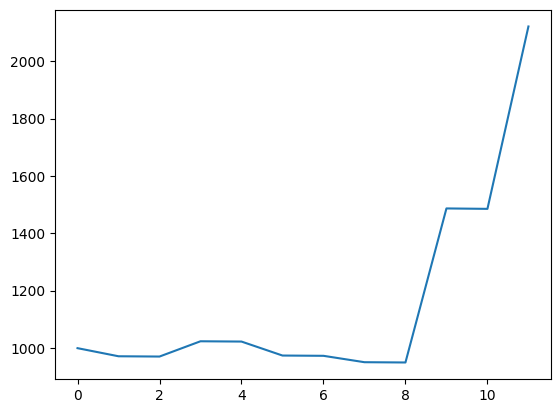

In [ ]:
trades.wallet.plot()


Starting amount: 1,000.00 USDT
Buy-Hold: 	 3,762.32 USDT	 (276.23% profit)
2-SMA: 		 2,121.62 USDT	 (112.16% profit)


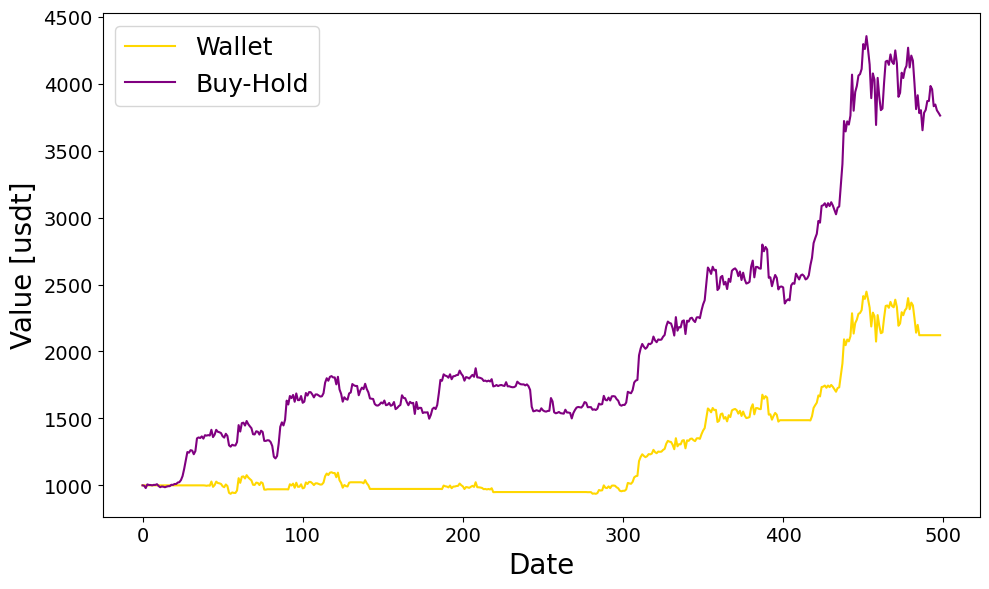

In [ ]:
print(
    "\nStarting amount: %s USDT"
    % (
        "{:0,.2f}".format(starting_usdt),

    )
)
print(
    "Buy-Hold: \t %s USDT\t (%s%% profit)"
    % (
        "{:0,.2f}".format(buyhold[-1]),
        "{:0,.2f}".format((buyhold[-1] / starting_usdt - 1) * 100),
    )
)
print(
    "2-SMA: \t\t %s USDT\t (%s%% profit)"
    % (
        "{:0,.2f}".format(wallet[-1]),
        "{:0,.2f}".format((wallet[-1] / starting_usdt - 1) * 100),
    )
)

plt.figure(figsize=(10, 6))
plt.plot(
    data.index,
    wallet,
    label="Wallet",
    color="gold",
)
plt.plot(
    data.index,
    buyhold,
    label="Buy-Hold",
    color="purple",
)
plt.legend(fontsize=18, loc="upper left")
plt.ylabel("Value [usdt]", fontsize=20)
plt.yticks(fontsize=14)
plt.xlabel("Date", fontsize=20)
plt.xticks(fontsize=14)
plt.tight_layout()

In [ ]:
def run_bot():
    print(f"Fetching new bars for {datetime.datetime.now().isoformat()}")
    bars = exchange.fetch_ohlcv('ETH/USDT', timeframe='1m', limit=100)
    df = pd.DataFrame(bars[:-1], columns=['date', 'open', 'high', 'low', 'close', 'volume'])
    df['date'] = pd.to_datetime(df['date'], unit='ms')

    df['date'] = df['date'].dt.strftime('%Y-%m-%d %H:%M:%S')
    return df

run_bot()

In [ ]:
# -*- coding: utf-8 -*-

import os
import sys
# import asciichart

import ccxt  # noqa: E402
binance = ccxt.binance()
symbol = 'BTC/USDT'
timeframe = '1h'

# each ohlcv candle is a list of [ timestamp, open, high, low, close, volume ]
index = 4  # use close price from each ohlcv candle

height = 15
length = 80


def print_chart(exchange, symbol, timeframe):

   print("\n" + exchange.name + ' ' + symbol + ' ' + timeframe + ' chart:')

   # get a list of ohlcv candles
   ohlcv = exchange.fetch_ohlcv(symbol, timeframe)

   # get the ohlCv (closing price, index == 4)
   series = [x[index] for x in ohlcv]

   # print the chart
#    print("\n" + asciichart.plot(series[-length:], {'height': height}))  # print the chart

   last = ohlcv[len(ohlcv) - 1][index]  # last closing price
   return last


last = print_chart(binance, symbol, timeframe)
print("\n" + binance.name + " ₿ = $" + str(last) + "\n")  # print last closing price
